# Example aggregation analysis notebook
### Author: Bill Flynn (bill.flynn@jax.org)

Updates:
- 2018-12-31: creation

This notebook assumes you have some familiarity with the `scanpy_recipes` extensions.  If not, check out `examples/Analysis-Template.ipynb` for more details.  This will be an abbreviated notebook just showing how things work with an aggregated sample.

In [1]:
from scanpy_recipes.api import sc

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Running Scanpy 1.3.4 on 2019-01-02 13:05.


## Loading data

In [2]:
ac = sc.AnalysisConfig()

In [3]:
config_string = """
[names]
customer_name = Anonymous person
analyst_name = Bill Flynn
analysis_name = Test-analysis

[sample_names]
PR18016 = CD45+
PR18017 = CD45-

[genomes]
PR18016 = GRCh38
PR18017 = GRCh38

[species]
hg19 = hsapiens
GRCh38 = hsapiens
mm10 = mmusculus

[input_dirs]
PR18016 = /projects/flynnb/singlecell/IBC/PR18016/
PR18017 = /projects/flynnb/singlecell/IBC/PR18017/

[output_dirs]
PR18016 = /fastscratch/flynnb/test-outputs
PR18017 = /fastscratch/flynnb/test-outputs
"""
config = ac.read(config_string)

Below, I'll be storing the adata objects in an iterable so that you can get the sense for how this might scale with many samples.

In [4]:
combined_sampleid = "PR18016-PR18017"
combined_sample_name = "CD45+/-"
combined_output_dir = "/fastscratch/flynnb/test-aggr-outputs"

In [5]:
sampleids = config["sample_names"]

In [6]:
adata_raws = dict((sampleid, sc.load_10x_data(sampleid, config)) for sampleid in sampleids)

reading /projects/flynnb/singlecell/IBC/PR18016/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:00.73)
Ran `.var_names_make_unique()` for you.
reading /projects/flynnb/singlecell/IBC/PR18017/filtered_gene_bc_matrices_h5.h5 

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


(0:00:00.68)
Ran `.var_names_make_unique()` for you.


## Quality control and filtering

Analysis first starts by generating **per-cell** and **per-gene** metrics, that we can then use to filter the data.  We compute these before we do any aggregation

In [7]:
for adata_raw in adata_raws.values():
    sc.qc.gen_qc(adata_raw)

hemoglobin_counts False
n_counts False
n_genes False
percent_mito False
sequencing_saturation False
hemoglobin_counts False
n_counts False
n_genes False
percent_mito False
sequencing_saturation False


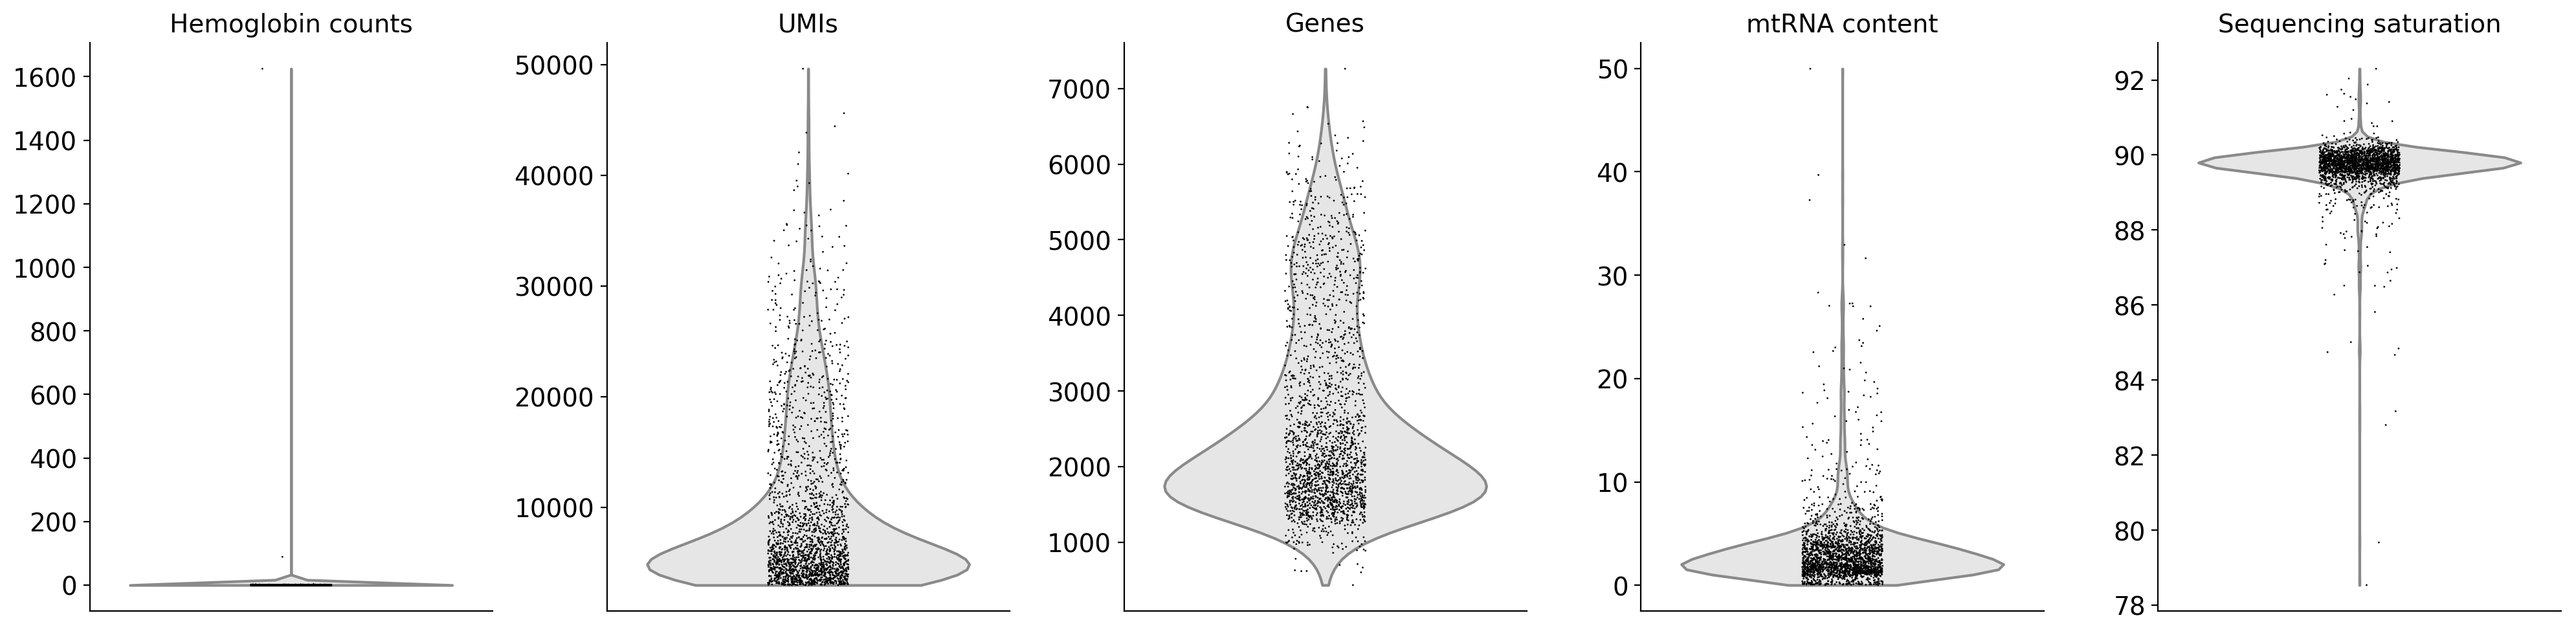

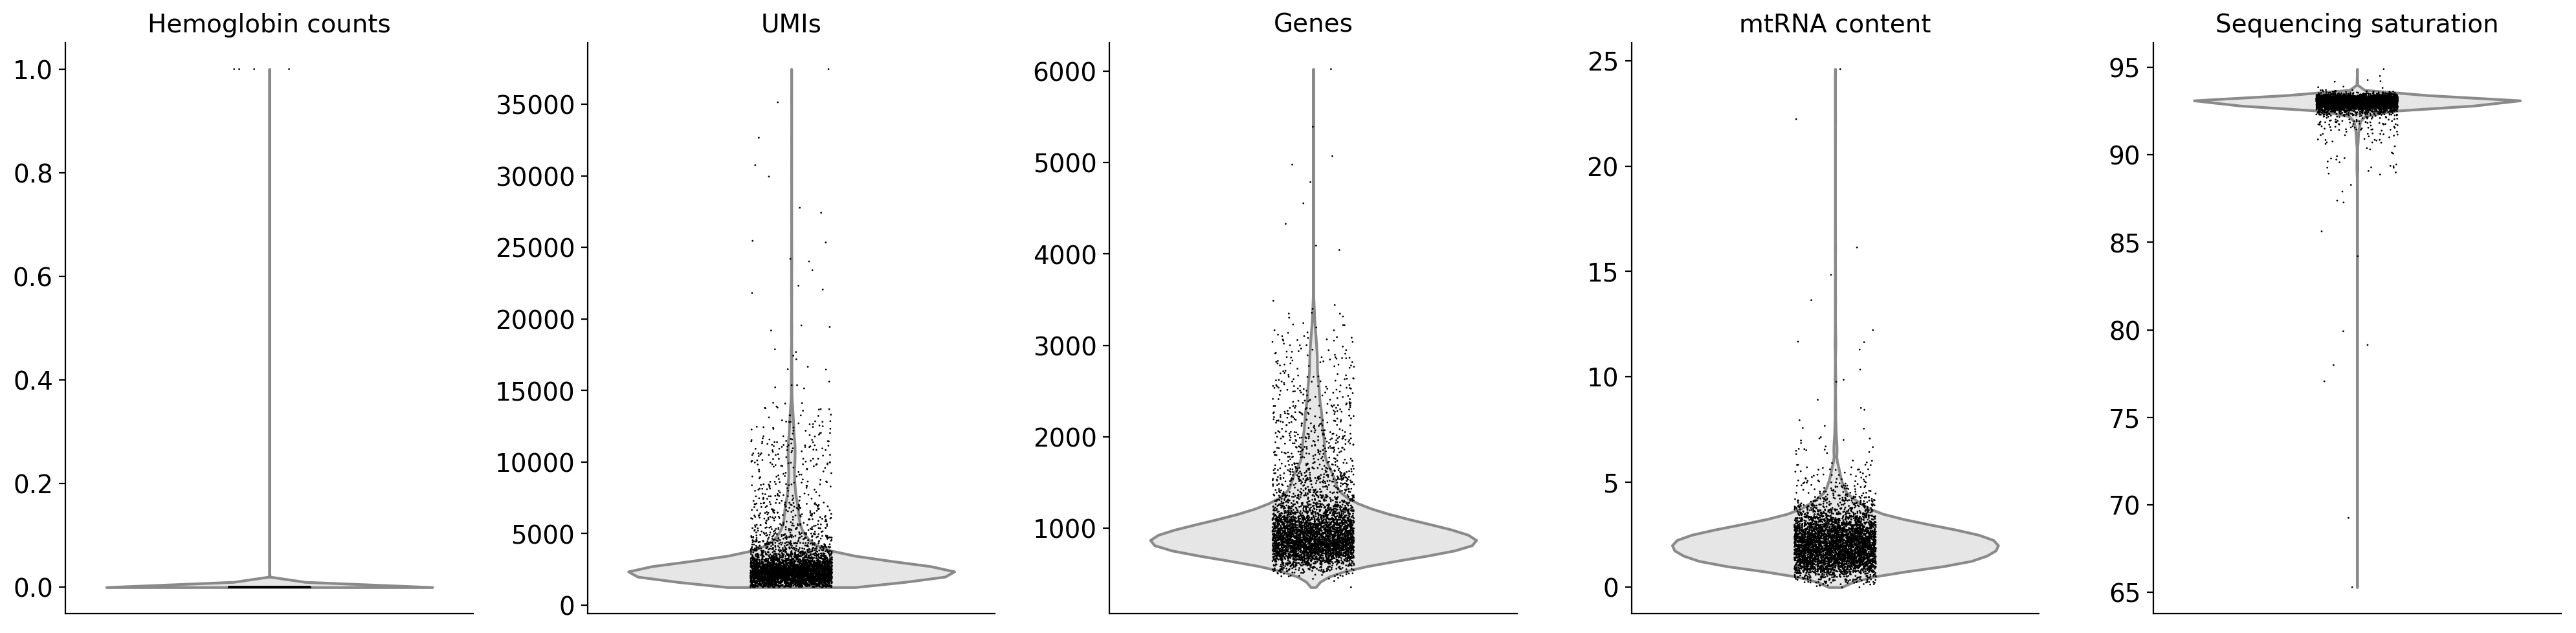

In [8]:
for adata_raw in adata_raws.values():
    sc.pl.qc_violins(adata_raw)

Either use one set of QC params that can be used all samples or use individual params. Below is one way to do this.

In [9]:
qc_params = dict(
    min_cells_per_gene=3,
    min_counts_per_gene=3,
    min_counts_per_cell=500,
    min_genes_per_cell=200,
    sequencing_saturation=None,
    percent_mito=10.0, 
    rbc_threshold=10
)
qc_params = dict((sampleid, qc_params.copy()) for sampleid in adata_raws.keys())

In [10]:
qc_params["PR18017"].update(percent_mito=5.0)

In [11]:
trials = [sc.qc.run_qc(adata_raw, trial=True, **qc_params[sampleid])
          for sampleid, adata_raw in adata_raws.items()]

filtered out 13967 genes that are detected in less than 3 cells
Original dims: (2145, 33694)
Filtered dims: (2048, 19727)
filtered out 16741 genes that are detected in less than 3 cells
Original dims: (4214, 33694)
Filtered dims: (4135, 16953)


hemoglobin_counts 10
n_counts 500
n_genes 200
percent_mito 10.0
sequencing_saturation None
hemoglobin_counts 10
n_counts 500
n_genes 200
percent_mito 5.0
sequencing_saturation None


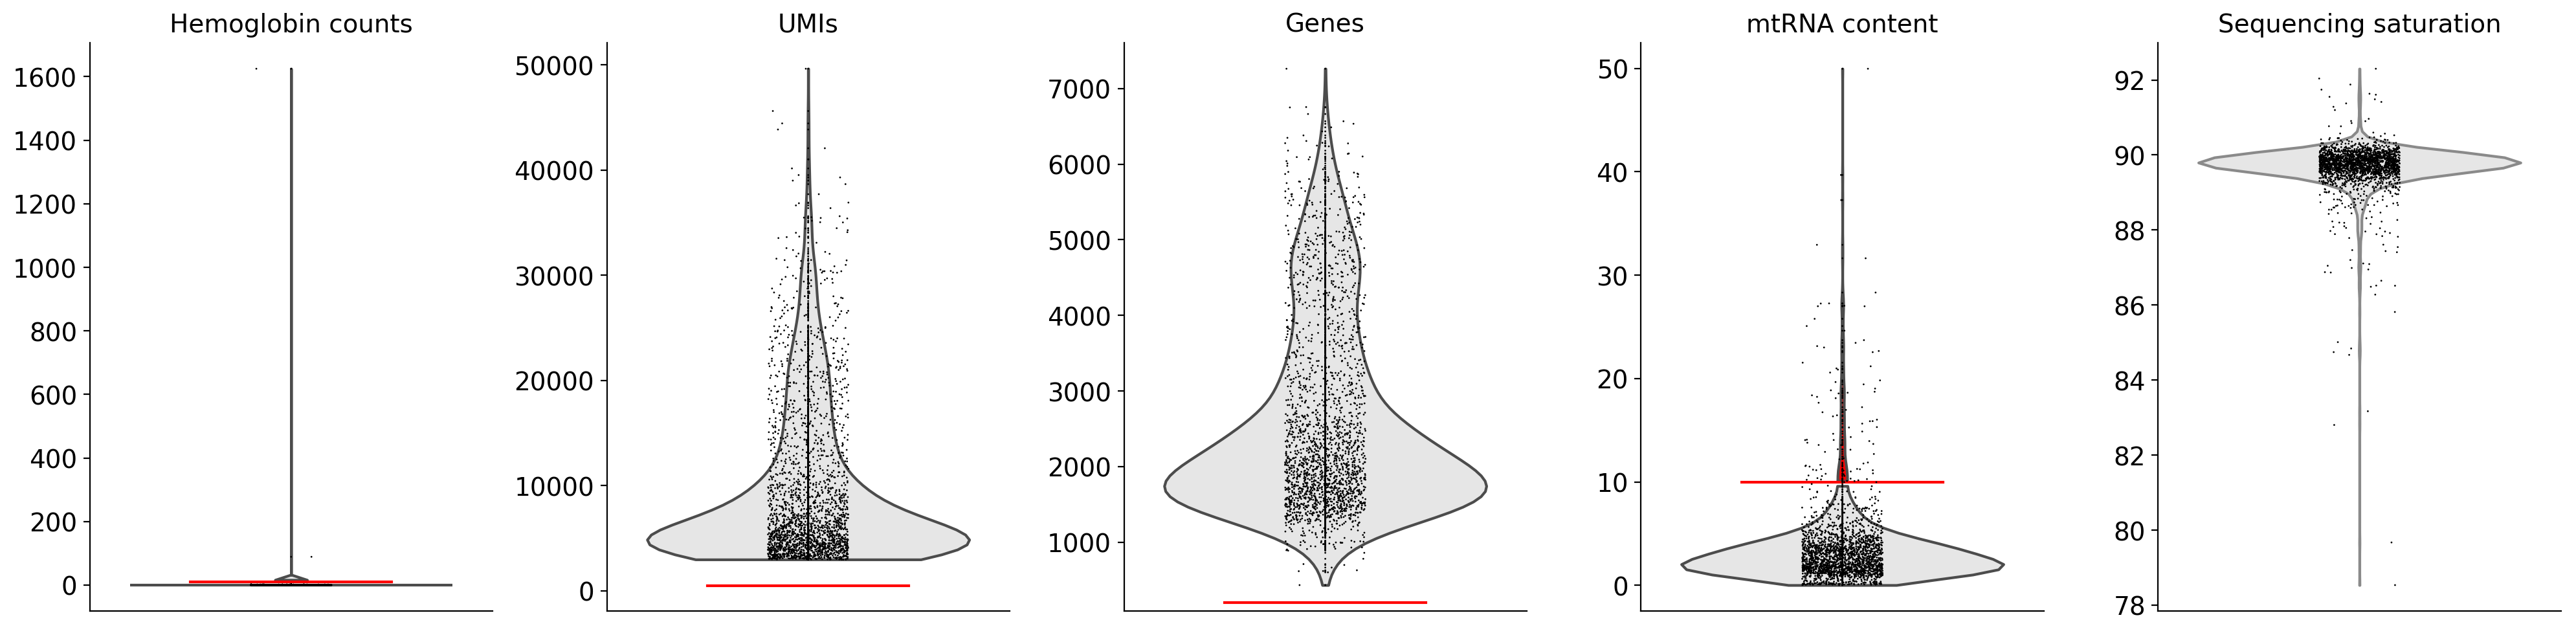

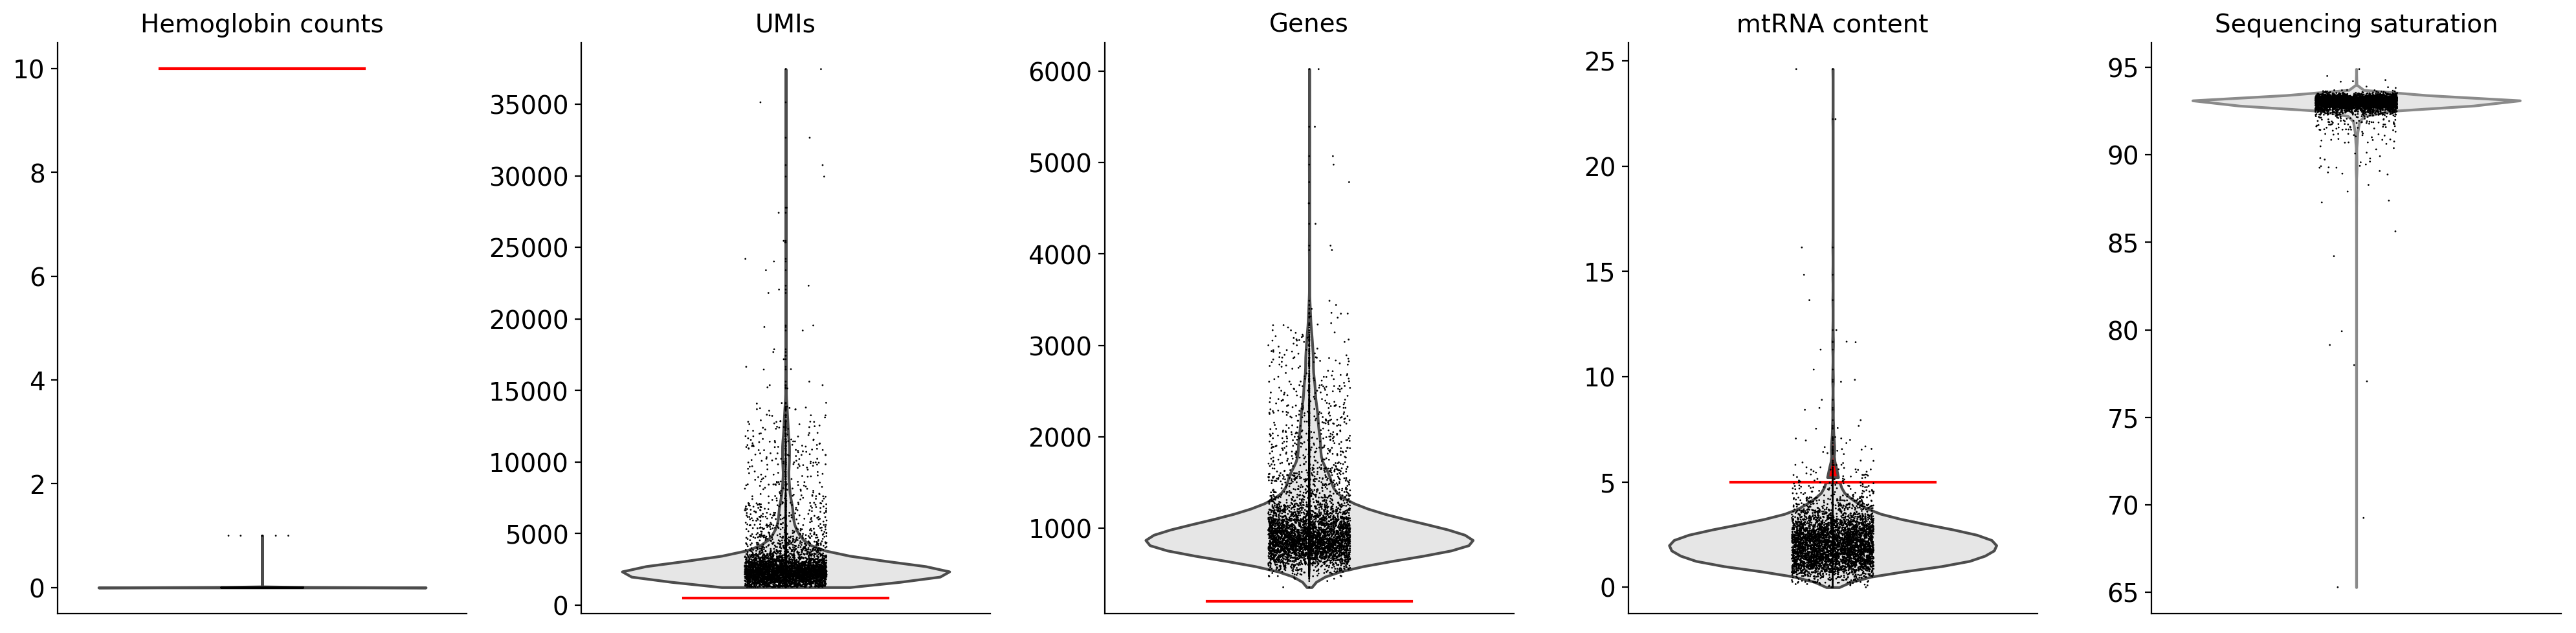

In [12]:
qc_figs = [sc.pl.qc_violins(trial, return_fig=True) for trial in trials]

In [13]:
adata_qcs = [sc.qc.run_qc(adata_raw, trial=False, **qc_params[sampleid])
             for sampleid, adata_raw in adata_raws.items()]

filtered out 13967 genes that are detected in less than 3 cells
Original dims: (2145, 33694)
Filtered dims: (2048, 19727)
filtered out 16741 genes that are detected in less than 3 cells
Original dims: (4214, 33694)
Filtered dims: (4135, 16953)


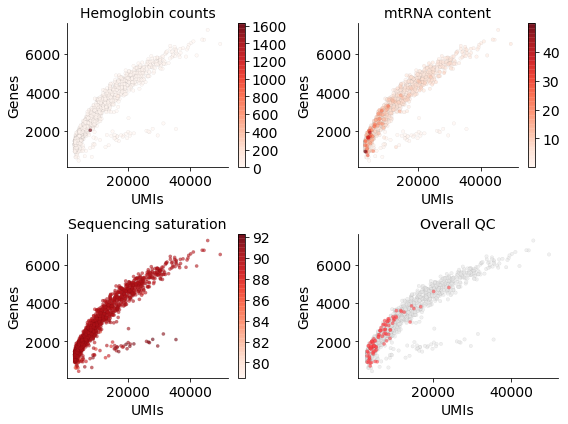

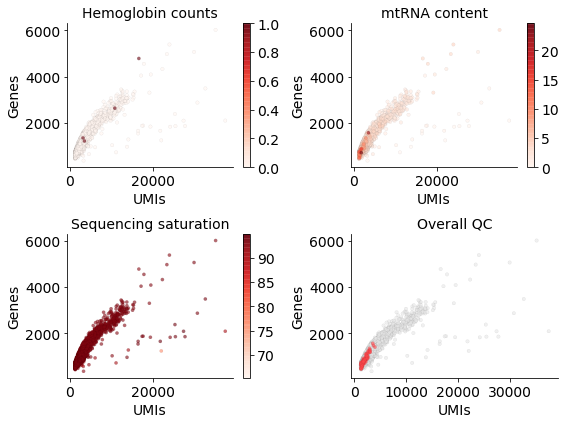

In [14]:
qc_figs2 = [sc.pl.genes_umis_scatter(trial, return_fig=True) for trial in trials]

## Aggregation time
Now let's aggregate them together.

In [15]:
combined_qc = sc.aggregate(
    adata_qcs,
    combined_output_dir=combined_output_dir,
    combined_sample_name=combined_sample_name,
    combined_sampleid=combined_sampleid,
    make_output_dir=True,
    del_batch_var=False
)

You can see that the following keys are added to `.obs`:
* `batch`
* `sampleid`
* `sample_name`

The keys added to `.var` are pretty redundant:
* `gene_ids == gene_ids-0 == gene_ids-1 == ...`
* `n_counts = n_counts-0 + n_counts-1 + ...`
* `n_genes = n_genes-0 + n_genes-1 + ...`

I can envision how having the counts/genes on a per-sample basis could be useful, so these are left in by default, but all these extra `.var` keys can be removed by passing `del_batch_var=True`.

In [16]:
print("New `.obs` keys")
print(f"old: {adata_raws['PR18016'].obs_keys()}\nnew: {combined_qc.obs_keys()}")
print("\nNew `.var` keys")
print(f"old: {adata_raws['PR18016'].var_keys()}\nnew: {combined_qc.var_keys()}")

New `.obs` keys
old: ['sequencing_saturation', 'percent_mito', 'hemoglobin_counts', 'n_counts', 'n_genes']
new: ['sequencing_saturation', 'percent_mito', 'hemoglobin_counts', 'n_counts', 'n_genes', 'batch', 'sampleid', 'sample_name']

New `.var` keys
old: ['gene_ids', 'n_counts', 'n_cells']
new: ['gene_ids-0', 'n_counts-0', 'n_cells-0', 'gene_ids-1', 'n_counts-1', 'n_cells-1', 'gene_ids', 'n_counts', 'n_cells']


The `.uns` data also gets an overhaul.  Entries that describe this analysis remain the same, but others that describe per-sample data have now become nested dictionaries, accessible via sampleID, e.g.
```
In : combined_qc.uns["10x_metrics"].keys()
Out: dict_keys(['PR18016', 'PR18017'])
In : combined_qc.uns["qc_cell_filter"].keys()
Out: dict_keys(['PR18016', 'PR18017'])
```
Important entries like `sample_name` and `sampleid` have been replaced by the `combined_` versions defined during `sc.aggregate` and the previous per-sample versions are moved to `sample_names` and `sampleids`, respectively.

In [17]:
combined_qc.uns_keys()

['10x_metrics',
 '10x_umi_cutoff',
 'analysis_version',
 'analyst',
 'customer_name',
 'date_created',
 'empty_genes',
 'genome',
 'input_dir',
 'input_file',
 'is_aggregation',
 'obs_titles',
 'output_dir',
 'qc_cell_filter',
 'qc_gene_filter',
 'qc_metrics',
 'raw_cells',
 'raw_genes',
 'sample_name',
 'sample_names',
 'sampleid',
 'sampleids',
 'species']

Everything from here continues **mostly** as usual.  Importantly, there is one additional key added to `.uns`:
```
In : combined_qc.uns["is_aggregation"]
Out: True
```
This signals to a few other methods to handle the sample differently.  For example, dimensionality reduction uses `bbknn` to construct the neighborhood graph and RDS saving will add an extra pseudogene denoting `batch`.

In [18]:
qc_save_file = sc.save_adata(combined_qc, "qc")

... storing 'sampleid' as categorical
... storing 'sample_name' as categorical


Saving PR18016-PR18017-qc_20190102.h5ad to /fastscratch/flynnb/test-aggr-outputs.


... storing 'gene_ids-0' as categorical
... storing 'gene_ids-1' as categorical


## HVG selection, dimensionality reduction, and clustering

In [19]:
adata_qc = sc.read_h5ad(qc_save_file)

In [20]:
adata_full, adata_redux = sc.pp.preprocess(adata_qc, n_top_genes=1000, scale=True)

If you pass `n_top_genes`, all cutoffs are ignored.


In [21]:
sc.pp.dimensionality_reduction(adata_redux,
                               n_neighbors=10, min_dist=0.5)

computing batch balanced neighbors
    finished (0:00:09.81) --> added to `.uns['neighbors']`
    'distances', weighted adjacency matrix
    'connectivities', weighted adjacency matrix
computing UMAP
    finished (0:00:16.46) --> added
    'X_umap', UMAP coordinates (adata.obsm)
computing UMAP
    finished (0:00:16.16) --> added
    'X_umap', UMAP coordinates (adata.obsm)
2D UMAP available at `.obsm['X_umap']`
3D UMAP available at `.obsm['X_umap_3d']`


We can visualize the aggregation by `"sample_name"`, `"sampleid"`, or `"batch"`!

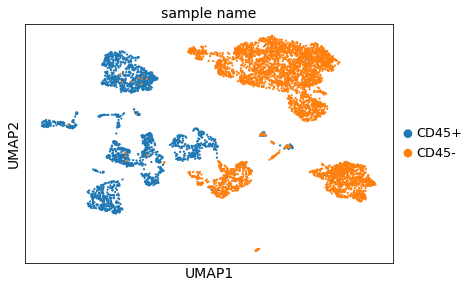

In [54]:
sc.pl.scatter(adata_redux, basis="umap", color="sample_name", show=False)

In [23]:
sc.tl.cluster(adata_redux,)

running Leiden clustering
    finished (0:00:00.81) --> found 26 clusters and added
    'cluster', the cluster labels (adata.obs, categorical)


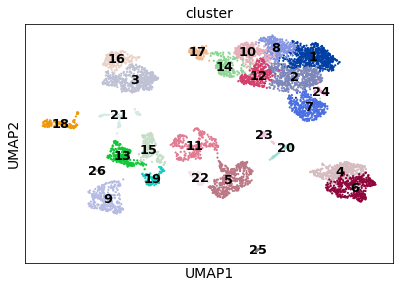

In [24]:
sc.pl.scatter(adata_redux, basis="umap", color="cluster", legend_loc="on data")

## Saving outputs

In [27]:
sc.save_adata_to_rds(adata_redux, cluster_key="cluster")

Saved counts to /fastscratch/flynnb/test-aggr-outputs/PR18016-PR18017_counts.csv.
Saved features to /fastscratch/flynnb/test-aggr-outputs/PR18016-PR18017_features.csv.
Saved umap3d to /fastscratch/flynnb/test-aggr-outputs/PR18016-PR18017_umap3d.csv.
Rds creation submitted as helix job 8957254.helix-master.
Output will be located in [/fastscratch/flynnb/test-aggr-outputs].


In [28]:
full_save_file = sc.save_adata(adata_full, "full")
redux_save_file = sc.save_adata(adata_redux, "redux")

Saving PR18016-PR18017-full_20181231.h5ad to /fastscratch/flynnb/test-aggr-outputs.
Saving PR18016-PR18017-redux_20181231.h5ad to /fastscratch/flynnb/test-aggr-outputs.


## Report generation

Report generation currently under construction for aggregated datasets.

In [25]:
report = sc.SCBLReport()

In [27]:
report.add_report_figures(
    adata_redux,
    violins=qc_figs,
    scatters=qc_figs2,
    cluster_key="cluster",
    batch_key="batch"
)

In [59]:
report.generate_report(adata_redux)

HTML report saved to [/fastscratch/flynnb/test-aggr-outputs/PR18016-PR18017_20190102_report.html].
